# Machine Learning HW5 - Hesam Korki

We need to first set the right environment for testing different approaches to the armed bandit problems


The general problem goal is to get an estimate of Qt(a):

   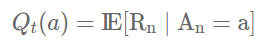
   
   
## Gereedy Method

The objective of this method is to only maximize the reward at each time step:

   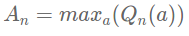

This means that we are only paying attention to the exploiting side of the problem, and exploring is not taking place. We could use a minute variable called epsilon for the method to explore a random action with that probability and exploit with the probability of (1 - eps), this is called eps-greedy. These two methods could efficiently be implemented with the same class:

In [65]:
#importing dependencies

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%config Completer.use_jedi = False

We define a class to represent the greedy method as an object with the following attributes:
- *k*: number of arms (int)
- *eps*: probability of random action (float)
- *iters*: number of steps (int)
- *rewards*: [default] is a set of random values normally distributed with mean = 0, could be set to a arbitrary array of size 'k'
- *decay*: [default] is set to NO, could be set to either EXP or INV

In [72]:
class GreedyBandit:
    
    def __init__(self, k, eps, iters, rewards='random', decay="NO"):
        
        self.k = k
        self.decay = decay
        if decay=="NO":
            self.eps = eps
        elif decay =="EXP":
            self.eps = math.exp(-1)
        else:
            self.eps = 1
            
        self.iters = iters
        
        #step count
        self.n = 0
        
        #step count for each arm
        self.k_n = np.zeros(k)
        
        #mean value
        self.mean = 0
        
        #reward history
        self.history = np.zeros(iters)
        
        #each arm reward history
        self.k_history = np.zeros(k)
        
        if type(rewards) == list or type(rewards).__module__ == np.__name__:
            #User-defined averages            
            self.rewards = np.array(rewards)
        elif rewards == 'random':
            #Draw means from probability distribution
            self.rewards = np.random.normal(0, 1, k)
    
    def calc_eps(self, t):
        if self.decay == "NO":
            return self.eps
        elif self.decay == "EXP":
            return math.exp(-(t+1))
        else:
            return 1/(t+1)
        
    def generate(self):
        
        p = np.random.rand()
        if self.eps == 0 and self.n == 0:
            a = np.random.choice(self.k)
        elif p < self.eps:
            # Random action
            a = np.random.choice(self.k)
        else:
            # Greedy action
            a = np.argmax(self.k_history)
            
        reward = np.random.normal(self.rewards[a], 1)
        
        self.n += 1
        self.k_n[a] += 1
        
        self.mean +=  (reward - self.mean)/self.n
        
        self.k_history[a] += (reward - self.k_history[a])/self.k_n[a]
        
        
    def go(self):
        
        for i in range(self.iters):
            self.eps = self.calc_eps(i)
            self.generate()
            self.history[i] = self.mean
    

We will compare results for the different amounts of epsilons, and assume that the bandit has 10 arms (k=10) and run 2000 steps for each epoch. 

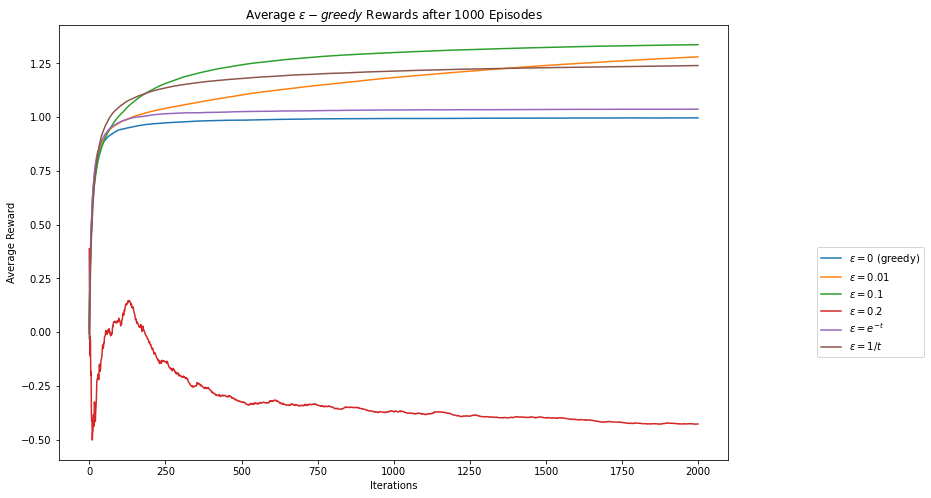

In [81]:
k = 10
iters = 2000

eps_0_rewards = np.zeros(iters)
eps_01_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)
eps_2_rewards = np.zeros(iters)
eps_exp_rewards = np.zeros(iters)
eps_inv_rewards = np.zeros(iters)

eps_0_selection = np.zeros(k)
eps_01_selection = np.zeros(k)
eps_1_selection = np.zeros(k)
eps_2_selection = np.zeros(k)

episodes = 1000
# Run experiments
for i in range(episodes):
    # Initialize bandits
    eps_0 = GreedyBandit(k, 0, iters)
    eps_01 = GreedyBandit(k, 0.01, iters, eps_0.rewards.copy())
    eps_1 = GreedyBandit(k, 0.1, iters, eps_0.rewards.copy())
    eps_2 = GreedyBandit(k, 0.2, iters, eps_0.rewards.copy())
    eps_exp = GreedyBandit(k, 0, iters, eps_0.rewards.copy(), decay="EXP")
    eps_inv = GreedyBandit(k, 0, iters, eps_0.rewards.copy(), decay="INV")
    
    # Run experiments
    eps_0.go()
    eps_01.go()
    eps_1.go()
    eps_2.go()
    eps_exp.go()
    eps_inv.go()
    
    # Update long-term averages
    eps_0_rewards = eps_0_rewards + (
        eps_0.history - eps_0_rewards) / (i + 1)
    eps_01_rewards = eps_01_rewards + (
        eps_01.history - eps_01_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.history - eps_1_rewards) / (i + 1)
    eps_2_rewards = eps_2_rewards + (
        eps_1.history - eps_1_rewards) / (i + 1)
    
    eps_exp_rewards += (eps_exp.history - eps_exp_rewards)/(i+1)
    eps_inv_rewards += (eps_inv.history - eps_inv_rewards)/(i+1)
    
    # Average actions per episode
    eps_0_selection += (eps_0.k_n - eps_0_selection)/(i+1)
    eps_01_selection += (eps_01.k_n - eps_01_selection)/(i+1)
    eps_1_selection += (eps_1.k_n - eps_1_selection)/(i+1)
    eps_2_selection += (eps_2.k_n - eps_2_selection)/(i+1)
    
    
plt.figure(figsize=(12,8))
plt.plot(eps_0_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_01_rewards, label="$\epsilon=0.01$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.plot(eps_2_rewards, label="$\epsilon=0.2$")
plt.plot(eps_exp_rewards, label="$\epsilon=e^{-t}$")
plt.plot(eps_inv_rewards, label="$\epsilon=1/t$")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes) 
    + " Episodes")
plt.show()

As we expected the epsilon-greedy method achieves better results than the greedy method which only exploits. However, when the amount of epsilon exceedes a certain amount like 0.2 the average reward would be unstable and would not definitely converge. Another diagram that is worthed to plot is the percentage of choosing the efficient action through iterations.

In [86]:
opt_per = np.array([eps_0_selection, eps_01_selection,
                   eps_1_selection]) / iters * 100
df = pd.DataFrame(opt_per, index=['$\epsilon=0$', 
    '$\epsilon=0.01$', '$\epsilon=0.1$'],
                 columns=["a = " + str(x) for x in range(0, k)])
print("Percentage of actions selected:")
df

Percentage of actions selected:


,a = 0,a = 1,a = 2,a = 3,a = 4,a = 5,a = 6,a = 7,a = 8,a = 9
$\epsilon=0$,22.04920,17.71800,15.47150,9.41005,8.6857,7.56030,5.68110,5.39840,4.71855,3.30720
$\epsilon=0.01$,18.04775,14.92025,13.21070,10.14700,9.4126,7.54215,7.19155,6.92110,6.65855,5.94835
$\epsilon=0.1$,11.13930,10.98400,10.20865,10.36990,9.9822,8.74820,10.37335,9.33645,9.32580,9.53215


## SoftMax Algorithm


The softmax method provides better optimization in comparison to epsilon-greedy method in terms of enhancing the chance of rewards during expolarion. In any round, instead of exploring other arms with same chance, it would take the difference of current average reward of each arm into account. 

   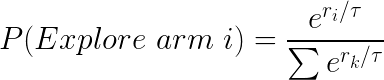
   
We will define a class to implement the softmax algorithm with constant tau and variyng tau. Our class would have the following attributes to simulate the algorithm:
- *k*: number of arms
- *alpha*: the learning rate
- *iters*: number of steps
- *dist*: distribution of rewards
    

In [79]:
class SoftBandit:
    def __init__(self, k, alpha, iters, dist='random', decay='NO'):
        self.k = k
        self.actions = np.arange(k)
        self.decay = decay
        if decay=="NO":
            self.alpha = alpha
        elif decay =="EXP":
            self.alpha = math.exp(-1)
        else:
            self.alpha = 1
        
        self.iters = iters
        # Step count
        self.n = 0
        
        self.k_n = np.zeros(k)
        
        self.mean = 0
        self.history = np.zeros(iters)
        
        self.k_history = np.zeros(k)
        
        self.H = np.zeros(k)
        
        
        if type(dist) == list or type(dist).__module__ == np.__name__:
            #User-defined averages            
            self.dist = np.array(dist)
        elif dist == 'random':
            #Draw means from probability distribution
            self.dist = np.random.normal(0, 1, k)
    
    def calc_alpha(self, t):
        if self.decay == "NO":
            return self.alpha
        elif self.decay == "EXP":
            return math.exp(-(t+1))
        else:
            return 1/(t+1)

    
    def explore(self):
        
        self.prob_action = np.exp(self.H - np.max(self.H)) / np.sum(np.exp(self.H - np.max(self.H)), axis=0)
    
    def generate(self):
        
        self.explore()
        
        a = np.random.choice(self.actions, p=self.prob_action)
        
        reward = np.random.normal(self.dist[a], 1)
        
        self.n += 1
        self.k_n[a] += 1
        
        self.mean += (reward - self.mean)/ self.n
        
        self.k_history[a] += (reward - self.k_history[a])/self.k_n[a]
        
        learn = self.alpha * (reward - self.mean) * (1 - self.prob_action[a])
        
        self.H[a] += learn
        
        actions_not_taken = self.actions != a
        
        regret = self.alpha * (reward - self.mean) * self.prob_action[actions_not_taken]
        self.H[actions_not_taken] -= regret
        
    def go(self):
        
        for i in range(self.iters):
            self.alpha = self.calc_alpha(i)
            self.generate()
            self.history[i] = self.mean
        
        

We would assume a 10 armed bandit with 2000 steps 

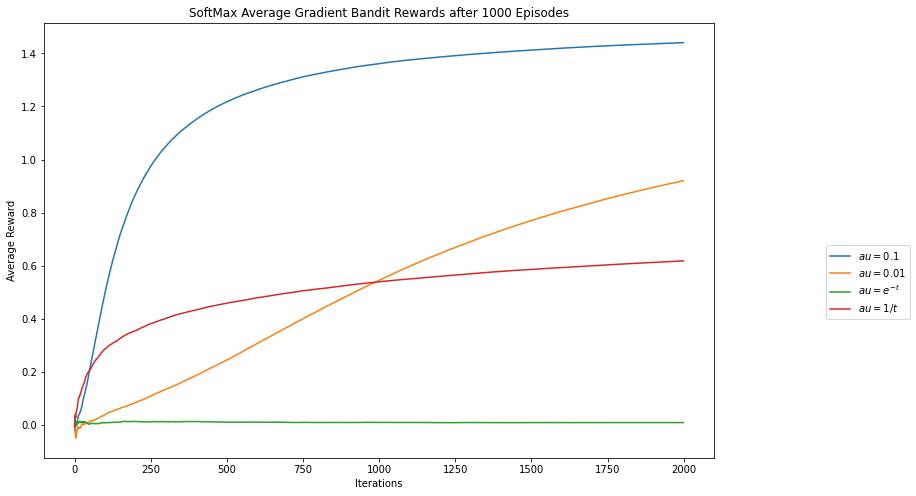

In [99]:
k = 10
iters = 2000

soft_1_rewards = np.zeros(iters)
soft_01_rewards = np.zeros(iters)
soft_exp_rewards = np.zeros(iters)
soft_inv_rewards = np.zeros(iters)

opt_01 = np.zeros(k)
opt_1 = np.zeros(k)
opt_exp = np.zeros(k)
opt_inv = np.zeros(k)
 
episodes = 1000
# Run experiments
for i in range(episodes):
    soft_1 = SoftBandit(k, 0.1, iters)
    soft_01 = SoftBandit(k, 0.01, iters, soft_1.dist.copy())
    soft_exp = SoftBandit(k, 0, iters, soft_1.dist.copy(), decay="EXP")
    soft_inv = SoftBandit(k, 0, iters, soft_1.dist.copy(), decay="INV")
    # Run experiments
    soft_1.go()
    soft_01.go()
    soft_exp.go()
    soft_inv.go()
     
    # Update long-term averages
    soft_1_rewards += (soft_1.history - soft_1_rewards) / (i + 1)
    soft_01_rewards += (soft_01.history - soft_01_rewards) / (i + 1)
    soft_exp_rewards += (soft_exp.history - soft_exp_rewards) / (i + 1)
    soft_inv_rewards += (soft_inv.history - soft_inv_rewards) / (i + 1)
    
    # Count optimal actions
    opt_1 += (soft_1.k_n - opt_1)/(i+1)
    opt_01 += (soft_01.k_n - opt_01)/(i+1)
    opt_exp += (soft_exp.k_n - opt_exp)/(i+1)
    opt_inv += (soft_inv.k_n - opt_inv)/(i+1)
     
plt.figure(figsize=(12,8))
plt.plot(soft_1_rewards, label='$\tau=0.1$')
plt.plot(soft_01_rewards, label='$\tau=0.01$')
plt.plot(soft_exp_rewards, label='$\tau=e^{-t}$')
plt.plot(soft_inv_rewards, label='$\tau=1/t$')
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("SoftMax Average Gradient Bandit Rewards after "
          + str(episodes) + " Episodes")
plt.show()

In [96]:
opt_per = np.array([opt_01, opt_1, opt_exp, opt_inv]) / iters * 100
df = pd.DataFrame(opt_per, index=['$\tau=0.01$', 
    '$\tau=0.1$', '$\tau=e^{-t}$', '$\tau=1/t$'],
                 columns=["a = " + str(x) for x in range(0, k)])
print("Percentage of actions selected:")
df

Percentage of actions selected:


,a = 0,a = 1,a = 2,a = 3,a = 4,a = 5,a = 6,a = 7,a = 8,a = 9
$\tau=0.01$,9.71685,10.62075,10.42555,9.80365,9.90700,10.76395,9.55970,9.82410,9.79745,9.58100
$\tau=0.1$,9.51420,10.07300,11.10605,9.73905,10.36750,12.42480,9.37645,9.55875,9.70560,8.13460
$\tau=e^{-t}$,10.00620,10.03335,10.04800,9.99260,10.01890,10.01070,9.96675,9.96970,10.00100,9.95280
$\tau=1/t$,9.37475,10.15715,10.45350,9.84910,9.54705,10.25405,10.00400,10.03215,10.08470,10.24355


## Optimistic Initial Value

In contrary to other methods, this approach does not explore using random noise to find the best action. Instead, we over estimate the rewards of all the actions and select the maximum. This algorithm needs some information about the rewards before hand to estimate them. We can use the epsilon-greedy implementation with epsilon=0 and provide high initial values.

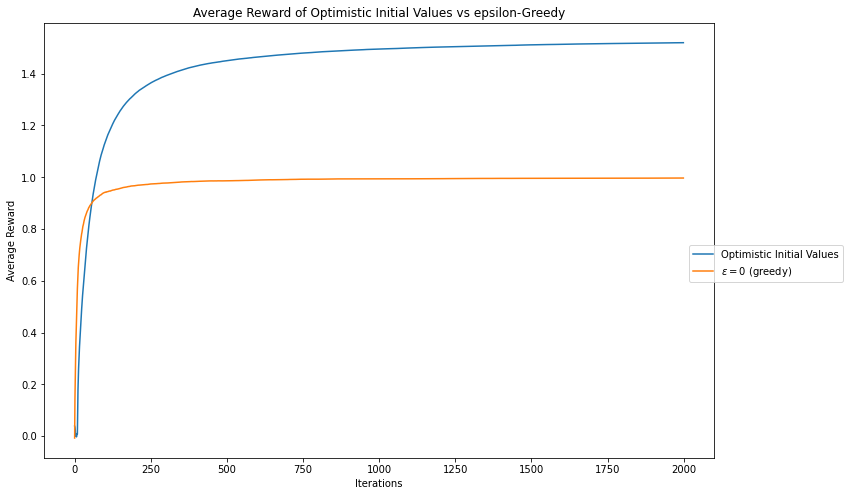

In [98]:
k = 10
iters = 2000

oiv_rewards = np.zeros(iters)
oiv_init = np.repeat(5., k)

opt_oiv = np.zeros(k)

for i in range(1000):
    oiv_bandit = GreedyBandit(k, 0, iters)
    oiv_bandit.k_history = oiv_init.copy()
    oiv_bandit.k_n = np.ones(k)
    
    oiv_bandit.go()
    
    oiv_rewards += (oiv_bandit.history - oiv_rewards)/(i+1)
    opt_oiv += (oiv_bandit.k_n - opt_oiv)/(i+1)
    
plt.figure(figsize=(12,8))
plt.plot(oiv_rewards, label="Optimistic Initial Values")
plt.plot(eps_0_rewards, label="$\epsilon=0$ (greedy)")
plt.legend(bbox_to_anchor=(1.2,0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average Reward of Optimistic Initial Values vs epsilon-Greedy")
plt.show()

In [100]:
opt_per = np.array([eps_0_selection, opt_oiv]) / iters * 100
df = pd.DataFrame(opt_per, index=['$\epsilon=0$', 'OIV'],
                 columns=["a = " + str(x) for x in range(0, k)])
print("Percentage of actions selected:")
df

Percentage of actions selected:


,a = 0,a = 1,a = 2,a = 3,a = 4,a = 5,a = 6,a = 7,a = 8,a = 9
$\epsilon=0$,22.04920,17.7180,15.4715,9.41005,8.6857,7.56030,5.6811,5.39840,4.71855,3.30720
OIV,8.96885,10.2129,10.2268,10.07570,9.6017,10.47505,9.7553,10.57555,10.21310,10.39505
